# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
from maddpg_agent import Agent
from collections import deque
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import torch

%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [ ]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [ ]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
# initialize agents
agent_0 = Agent(state_size, action_size)
agent_1 = Agent(state_size, action_size)


def train_maddpg(n_episodes: int=2000, max_t: int=1000) -> Tuple[List[float], List[float]]:
    """Multi-Agent Deep Deterministic Policy Gradient (MADDPG)

        :param n_episodes: maximum number of training episodes
        :param max_t: maximum number of timesteps per episode
    """
    scores_window = deque(maxlen=100)
    scores_all = []
    moving_average = []   
    best_score = -np.inf

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]         # reset the environment
        states = np.reshape(env_info.vector_observations, (1,48)) # get states and combine them
        agent_0.reset()
        agent_1.reset()
        scores = np.zeros(num_agents)
        while True:
            actions = get_actions(states, add_noise=True)      # choose agent actions and combine them
            env_info = env.step(actions)[brain_name]    # send both agents' actions together to the environment
            next_states = np.reshape(env_info.vector_observations, (1, 48)) # combine the agent next states
            rewards = env_info.rewards                         # get reward
            done = env_info.local_done                         # see if episode finished
            agent_0.step(states, actions, rewards[0], next_states, done, 0) # agent 1 learns
            agent_1.step(states, actions, rewards[1], next_states, done, 1) # agent 2 learns
            scores += np.max(rewards)                          # update the score for each agent
            states = next_states                               # roll over states to next time step
            if np.any(done):                                   # exit loop if episode finished
                break

        ep_best_score = np.max(scores)
        scores_window.append(ep_best_score)
        scores_all.append(ep_best_score)
        moving_average.append(np.mean(scores_window))
        
        # print results every 10 episodes
        if i_episode % 10 == 0:
            print('Episodes {:0>4d}-{:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
                i_episode-10, i_episode, np.max(scores_all[-10:]), moving_average[-1]))

        # determine if environment is solved and save the models
        if moving_average[-1] >= 0.5:
            print('*** Environment solved in {:d} episodes: Moving Average: {:.3f} over past {:d} episodes'
                  .format(i_episode-100, moving_average[-1], 100))
            # save weights
            torch.save(agent_0.actor_local.state_dict(), 'checkpoint_actor_0.pth')
            torch.save(agent_0.critic_local.state_dict(), 'checkpoint_critic_0.pth')
            torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_1.pth')
            torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_1.pth')
            break
            
    return scores_all, moving_average

In [7]:
def get_actions(states, add_noise):
    """gets actions for each agent and then combines them into one array"""
    action_0 = agent_0.act(states, add_noise)    # agent 0 chooses an action
    action_1 = agent_1.act(states, add_noise)    # agent 1 chooses an action
    return np.concatenate((action_0, action_1), axis=0).flatten()

In [8]:
# run the training loop
scores, avgs = train_maddpg()

Episodes 0000-0010	Max Reward: 0.000	Moving Average: 0.000
Episodes 0010-0020	Max Reward: 0.000	Moving Average: 0.000
Episodes 0020-0030	Max Reward: 0.000	Moving Average: 0.000
Episodes 0030-0040	Max Reward: 0.100	Moving Average: 0.003
Episodes 0040-0050	Max Reward: 0.100	Moving Average: 0.004
Episodes 0050-0060	Max Reward: 0.100	Moving Average: 0.007
Episodes 0060-0070	Max Reward: 0.100	Moving Average: 0.009
Episodes 0070-0080	Max Reward: 0.100	Moving Average: 0.013
Episodes 0080-0090	Max Reward: 0.300	Moving Average: 0.021
Episodes 0090-0100	Max Reward: 0.100	Moving Average: 0.022
Episodes 0100-0110	Max Reward: 0.200	Moving Average: 0.027
Episodes 0110-0120	Max Reward: 0.200	Moving Average: 0.030
Episodes 0120-0130	Max Reward: 0.100	Moving Average: 0.031
Episodes 0130-0140	Max Reward: 0.100	Moving Average: 0.032
Episodes 0140-0150	Max Reward: 0.300	Moving Average: 0.036
Episodes 0150-0160	Max Reward: 0.100	Moving Average: 0.036
Episodes 0160-0170	Max Reward: 0.300	Moving Average: 0.0

Episodes 1390-1400	Max Reward: 0.800	Moving Average: 0.273
Episodes 1400-1410	Max Reward: 0.800	Moving Average: 0.277
Episodes 1410-1420	Max Reward: 1.100	Moving Average: 0.285
Episodes 1420-1430	Max Reward: 1.000	Moving Average: 0.305
Episodes 1430-1440	Max Reward: 0.800	Moving Average: 0.304
Episodes 1440-1450	Max Reward: 1.000	Moving Average: 0.306
Episodes 1450-1460	Max Reward: 0.300	Moving Average: 0.299
Episodes 1460-1470	Max Reward: 0.600	Moving Average: 0.304
Episodes 1470-1480	Max Reward: 0.400	Moving Average: 0.289
Episodes 1480-1490	Max Reward: 0.500	Moving Average: 0.280
Episodes 1490-1500	Max Reward: 0.700	Moving Average: 0.278
Episodes 1500-1510	Max Reward: 0.500	Moving Average: 0.270
Episodes 1510-1520	Max Reward: 0.600	Moving Average: 0.274
Episodes 1520-1530	Max Reward: 0.600	Moving Average: 0.264
Episodes 1530-1540	Max Reward: 0.600	Moving Average: 0.273
Episodes 1540-1550	Max Reward: 0.600	Moving Average: 0.254
Episodes 1550-1560	Max Reward: 0.300	Moving Average: 0.2

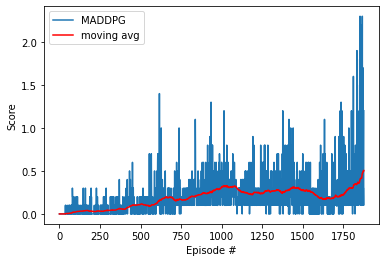

In [9]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='MADDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='moving avg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

Test saved agent

In [10]:
agent_0 = Agent(state_size, action_size)
agent_1 = Agent(state_size, action_size)

# load the weights from file
agent_0_weights = 'checkpoint_actor_0.pth'
agent_1_weights = 'checkpoint_actor_1.pth'
agent_0.actor_local.load_state_dict(torch.load(agent_0_weights))
agent_1.actor_local.load_state_dict(torch.load(agent_1_weights))

In [16]:
def test_maddpg(n_episodes=10, max_t=1000) -> Tuple[List[float], List[float]]:
    """Testing Multi-Agent Deep Deterministic Policy Gradient (MADDPG)

        :param n_episodes: maximum number of test episodes
        :param max_t: maximum number of timesteps per episode
    """
    scores_window = deque(maxlen=10)
    scores_all = []
    moving_average = []  

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=False)[brain_name]         # reset the environment
        states = np.reshape(env_info.vector_observations, (1, 48)) # get states and combine them
        scores = np.zeros(num_agents)
        while True:
            actions = get_actions(states, add_noise=False)   # choose agent actions and combine them
            env_info = env.step(actions)[brain_name]        # send both agents' actions together to the environment
            next_states = np.reshape(env_info.vector_observations, (1, 48)) # combine the agent next states
            rewards = env_info.rewards                         # get reward
            done = env_info.local_done                         # see if episode finished
            scores += np.max(rewards)                          # update the score for each agent
            states = next_states                               # roll over states to next time step
            if np.any(done):                                   # exit loop if episode finished
                break

        ep_best_score = np.max(scores)
        scores_window.append(ep_best_score)
        scores_all.append(ep_best_score)
        moving_average.append(np.mean(scores_window))

        # print results every episode
        print('Episodes {:0>4d}-{:0>4d}\tMax Reward: {:.3f}\tMoving Average: {:.3f}'.format(
            i_episode-1, i_episode, np.max(scores_all[-1:]), moving_average[-1]))
            
    return scores_all, moving_average

In [17]:
scores, avgs = test_maddpg()

Episodes 0000-0001	Max Reward: 0.300	Moving Average: 0.300
Episodes 0001-0002	Max Reward: 0.300	Moving Average: 0.300
Episodes 0002-0003	Max Reward: 1.500	Moving Average: 0.700
Episodes 0003-0004	Max Reward: 0.400	Moving Average: 0.625
Episodes 0004-0005	Max Reward: 0.600	Moving Average: 0.620
Episodes 0005-0006	Max Reward: 0.300	Moving Average: 0.567
Episodes 0006-0007	Max Reward: 0.900	Moving Average: 0.614
Episodes 0007-0008	Max Reward: 0.300	Moving Average: 0.575
Episodes 0008-0009	Max Reward: 0.300	Moving Average: 0.544
Episodes 0009-0010	Max Reward: 1.000	Moving Average: 0.590


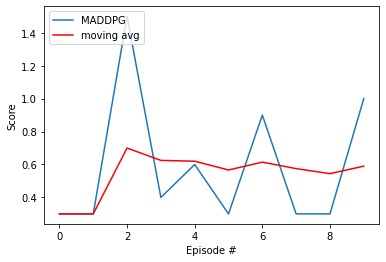

In [18]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='MADDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='moving avg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

In [19]:
env.close()